In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 1y6ktp79


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-1y6ktp79:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/659 [00:00<?, ?it/s]

  0%|                                                                      | 1/659 [00:00<06:14,  1.75it/s]

  0%|▎                                                                     | 3/659 [00:00<02:12,  4.95it/s]

  1%|▌                                                                     | 5/659 [00:00<01:28,  7.37it/s]

  1%|▋                                                                     | 7/659 [00:01<01:11,  9.13it/s]

  1%|▉                                                                     | 9/659 [00:01<01:02, 10.44it/s]

  2%|█▏                                                                   | 11/659 [00:01<00:56, 11.38it/s]

  2%|█▎                                                                   | 13/659 [00:01<00:53, 12.03it/s]

  2%|█▌                                                                   | 15/659 [00:01<00:51, 12.51it/s]

  3%|█▊                                                                   | 17/659 [00:01<00:50, 12.82it/s]

  3%|█▉                                                                   | 19/659 [00:01<00:48, 13.08it/s]

  3%|██▏                                                                  | 21/659 [00:02<00:48, 13.25it/s]

  3%|██▍                                                                  | 23/659 [00:02<00:47, 13.36it/s]

  4%|██▌                                                                  | 25/659 [00:02<00:47, 13.45it/s]

  4%|██▊                                                                  | 27/659 [00:02<00:46, 13.49it/s]

  4%|███                                                                  | 29/659 [00:02<00:46, 13.56it/s]

  5%|███▏                                                                 | 31/659 [00:02<00:46, 13.58it/s]

  5%|███▍                                                                 | 33/659 [00:02<00:46, 13.59it/s]

  5%|███▋                                                                 | 35/659 [00:03<00:45, 13.62it/s]

  6%|███▊                                                                 | 37/659 [00:03<00:45, 13.60it/s]

  6%|████                                                                 | 39/659 [00:03<00:45, 13.64it/s]

  6%|████▎                                                                | 41/659 [00:03<00:45, 13.61it/s]

  7%|████▌                                                                | 43/659 [00:03<00:45, 13.62it/s]

  7%|████▋                                                                | 45/659 [00:03<00:45, 13.64it/s]

  7%|████▉                                                                | 47/659 [00:03<00:44, 13.62it/s]

  7%|█████▏                                                               | 49/659 [00:04<00:44, 13.66it/s]

  8%|█████▎                                                               | 51/659 [00:04<00:44, 13.63it/s]

  8%|█████▌                                                               | 53/659 [00:04<00:44, 13.65it/s]

  8%|█████▊                                                               | 55/659 [00:04<00:44, 13.65it/s]

  9%|█████▉                                                               | 57/659 [00:04<00:44, 13.62it/s]

  9%|██████▏                                                              | 59/659 [00:04<00:43, 13.65it/s]

  9%|██████▍                                                              | 61/659 [00:04<00:43, 13.62it/s]

 10%|██████▌                                                              | 63/659 [00:05<00:43, 13.64it/s]

 10%|██████▊                                                              | 65/659 [00:05<00:43, 13.65it/s]

 10%|███████                                                              | 67/659 [00:05<00:43, 13.62it/s]

 10%|███████▏                                                             | 69/659 [00:05<00:43, 13.65it/s]

 11%|███████▍                                                             | 71/659 [00:05<00:43, 13.64it/s]

 11%|███████▋                                                             | 73/659 [00:05<00:43, 13.62it/s]

 11%|███████▊                                                             | 75/659 [00:05<00:42, 13.65it/s]

 12%|████████                                                             | 77/659 [00:06<00:42, 13.62it/s]

 12%|████████▎                                                            | 79/659 [00:06<00:42, 13.64it/s]

 12%|████████▍                                                            | 81/659 [00:06<00:42, 13.65it/s]

 13%|████████▋                                                            | 83/659 [00:06<00:42, 13.63it/s]

 13%|████████▉                                                            | 85/659 [00:06<00:42, 13.64it/s]

 13%|█████████                                                            | 87/659 [00:06<00:42, 13.61it/s]

 14%|█████████▎                                                           | 89/659 [00:07<00:41, 13.64it/s]

 14%|█████████▌                                                           | 91/659 [00:07<00:41, 13.64it/s]

 14%|█████████▋                                                           | 93/659 [00:07<00:41, 13.62it/s]

 14%|█████████▉                                                           | 95/659 [00:07<00:41, 13.65it/s]

 15%|██████████▏                                                          | 97/659 [00:07<00:41, 13.61it/s]

 15%|██████████▎                                                          | 99/659 [00:07<00:41, 13.64it/s]

 15%|██████████▍                                                         | 101/659 [00:07<00:40, 13.65it/s]

 16%|██████████▋                                                         | 103/659 [00:08<00:40, 13.62it/s]

 16%|██████████▊                                                         | 105/659 [00:08<00:40, 13.63it/s]

 16%|███████████                                                         | 107/659 [00:08<00:40, 13.60it/s]

 17%|███████████▏                                                        | 109/659 [00:08<00:40, 13.64it/s]

 17%|███████████▍                                                        | 111/659 [00:08<00:40, 13.61it/s]

 17%|███████████▋                                                        | 113/659 [00:08<00:40, 13.64it/s]

 17%|███████████▊                                                        | 115/659 [00:08<00:39, 13.65it/s]

 18%|████████████                                                        | 117/659 [00:09<00:39, 13.62it/s]

 18%|████████████▎                                                       | 119/659 [00:09<00:39, 13.65it/s]

 18%|████████████▍                                                       | 121/659 [00:09<00:39, 13.62it/s]

 19%|████████████▋                                                       | 123/659 [00:09<00:39, 13.63it/s]

 19%|████████████▉                                                       | 125/659 [00:09<00:39, 13.65it/s]

 19%|█████████████                                                       | 127/659 [00:09<00:39, 13.61it/s]

 20%|█████████████▎                                                      | 129/659 [00:09<00:38, 13.64it/s]

 20%|█████████████▌                                                      | 131/659 [00:10<00:38, 13.61it/s]

 20%|█████████████▋                                                      | 133/659 [00:10<00:38, 13.63it/s]

 20%|█████████████▉                                                      | 135/659 [00:10<00:38, 13.66it/s]

 21%|██████████████▏                                                     | 137/659 [00:10<00:38, 13.62it/s]

 21%|██████████████▎                                                     | 139/659 [00:10<00:38, 13.65it/s]

 21%|██████████████▌                                                     | 141/659 [00:10<00:37, 13.65it/s]

 22%|██████████████▊                                                     | 143/659 [00:10<00:37, 13.63it/s]

 22%|██████████████▉                                                     | 145/659 [00:11<00:37, 13.64it/s]

 22%|███████████████▏                                                    | 147/659 [00:11<00:37, 13.61it/s]

 23%|███████████████▎                                                    | 149/659 [00:11<00:37, 13.64it/s]

 23%|███████████████▌                                                    | 151/659 [00:11<00:37, 13.62it/s]

 23%|███████████████▊                                                    | 153/659 [00:11<00:37, 13.63it/s]

 24%|███████████████▉                                                    | 155/659 [00:11<00:36, 13.64it/s]

 24%|████████████████▏                                                   | 157/659 [00:12<00:36, 13.61it/s]

 24%|████████████████▍                                                   | 159/659 [00:12<00:36, 13.64it/s]

 24%|████████████████▌                                                   | 161/659 [00:12<00:36, 13.61it/s]

 25%|████████████████▊                                                   | 163/659 [00:12<00:36, 13.63it/s]

 25%|█████████████████                                                   | 165/659 [00:12<00:36, 13.66it/s]

 25%|█████████████████▏                                                  | 167/659 [00:12<00:36, 13.63it/s]

 26%|█████████████████▍                                                  | 169/659 [00:12<00:35, 13.65it/s]

 26%|█████████████████▋                                                  | 171/659 [00:13<00:35, 13.65it/s]

 26%|█████████████████▊                                                  | 173/659 [00:13<00:35, 13.63it/s]

 27%|██████████████████                                                  | 175/659 [00:13<00:35, 13.64it/s]

 27%|██████████████████▎                                                 | 177/659 [00:13<00:35, 13.61it/s]

 27%|██████████████████▍                                                 | 179/659 [00:13<00:35, 13.64it/s]

 27%|██████████████████▋                                                 | 181/659 [00:13<00:35, 13.62it/s]

 28%|██████████████████▉                                                 | 183/659 [00:13<00:34, 13.63it/s]

 28%|███████████████████                                                 | 185/659 [00:14<00:34, 13.64it/s]

 28%|███████████████████▎                                                | 187/659 [00:14<00:34, 13.63it/s]

 29%|███████████████████▌                                                | 189/659 [00:14<00:34, 13.65it/s]

 29%|███████████████████▋                                                | 191/659 [00:14<00:34, 13.62it/s]

 29%|███████████████████▉                                                | 193/659 [00:14<00:34, 13.63it/s]

 30%|████████████████████                                                | 195/659 [00:14<00:34, 13.64it/s]

 30%|████████████████████▎                                               | 197/659 [00:14<00:33, 13.61it/s]

 30%|████████████████████▌                                               | 199/659 [00:15<00:33, 13.65it/s]

 31%|████████████████████▋                                               | 201/659 [00:15<00:33, 13.62it/s]

 31%|████████████████████▉                                               | 203/659 [00:15<00:33, 13.63it/s]

 31%|█████████████████████▏                                              | 205/659 [00:15<00:33, 13.66it/s]

 31%|█████████████████████▎                                              | 207/659 [00:15<00:33, 13.63it/s]

 32%|█████████████████████▌                                              | 209/659 [00:15<00:32, 13.66it/s]

 32%|█████████████████████▊                                              | 211/659 [00:15<00:32, 13.63it/s]

 32%|█████████████████████▉                                              | 213/659 [00:16<00:32, 13.65it/s]

 33%|██████████████████████▏                                             | 215/659 [00:16<00:32, 13.66it/s]

 33%|██████████████████████▍                                             | 217/659 [00:16<00:32, 13.65it/s]

 33%|██████████████████████▌                                             | 219/659 [00:16<00:32, 13.68it/s]

 34%|██████████████████████▊                                             | 221/659 [00:16<00:32, 13.63it/s]

 34%|███████████████████████                                             | 223/659 [00:16<00:31, 13.65it/s]

 34%|███████████████████████▏                                            | 225/659 [00:16<00:31, 13.67it/s]

 34%|███████████████████████▍                                            | 227/659 [00:17<00:31, 13.64it/s]

 35%|███████████████████████▋                                            | 229/659 [00:17<00:31, 13.67it/s]

 35%|███████████████████████▊                                            | 231/659 [00:17<00:31, 13.63it/s]

 35%|████████████████████████                                            | 233/659 [00:17<00:31, 13.65it/s]

 36%|████████████████████████▏                                           | 235/659 [00:17<00:31, 13.66it/s]

 36%|████████████████████████▍                                           | 237/659 [00:17<00:30, 13.62it/s]

 36%|████████████████████████▋                                           | 239/659 [00:18<00:30, 13.66it/s]

 37%|████████████████████████▊                                           | 241/659 [00:18<00:30, 13.63it/s]

 37%|█████████████████████████                                           | 243/659 [00:18<00:30, 13.64it/s]

 37%|█████████████████████████▎                                          | 245/659 [00:18<00:30, 13.66it/s]

 37%|█████████████████████████▍                                          | 247/659 [00:18<00:30, 13.63it/s]

 38%|█████████████████████████▋                                          | 249/659 [00:18<00:30, 13.65it/s]

 38%|█████████████████████████▉                                          | 251/659 [00:18<00:29, 13.63it/s]

 38%|██████████████████████████                                          | 253/659 [00:19<00:29, 13.63it/s]

 39%|██████████████████████████▎                                         | 255/659 [00:19<00:29, 13.65it/s]

 39%|██████████████████████████▌                                         | 257/659 [00:19<00:29, 13.62it/s]

 39%|██████████████████████████▋                                         | 259/659 [00:19<00:29, 13.65it/s]

 40%|██████████████████████████▉                                         | 261/659 [00:19<00:29, 13.65it/s]

 40%|███████████████████████████▏                                        | 263/659 [00:19<00:29, 13.63it/s]

 40%|███████████████████████████▎                                        | 265/659 [00:19<00:28, 13.65it/s]

 41%|███████████████████████████▌                                        | 267/659 [00:20<00:28, 13.63it/s]

 41%|███████████████████████████▊                                        | 269/659 [00:20<00:28, 13.66it/s]

 41%|███████████████████████████▉                                        | 271/659 [00:20<00:28, 13.66it/s]

 41%|████████████████████████████▏                                       | 273/659 [00:20<00:28, 13.64it/s]

 42%|████████████████████████████▍                                       | 275/659 [00:20<00:28, 13.65it/s]

 42%|████████████████████████████▌                                       | 277/659 [00:20<00:28, 13.63it/s]

 42%|████████████████████████████▊                                       | 279/659 [00:20<00:27, 13.65it/s]

 43%|████████████████████████████▉                                       | 281/659 [00:21<00:27, 13.56it/s]

 43%|█████████████████████████████▏                                      | 283/659 [00:21<00:27, 13.57it/s]

 43%|█████████████████████████████▍                                      | 285/659 [00:21<00:27, 13.71it/s]

 44%|█████████████████████████████▌                                      | 287/659 [00:21<00:27, 13.67it/s]

 44%|█████████████████████████████▊                                      | 289/659 [00:21<00:27, 13.70it/s]

 44%|██████████████████████████████                                      | 291/659 [00:21<00:26, 13.65it/s]

 44%|██████████████████████████████▏                                     | 293/659 [00:21<00:26, 13.65it/s]

 45%|██████████████████████████████▍                                     | 295/659 [00:22<00:26, 13.66it/s]

 45%|██████████████████████████████▋                                     | 297/659 [00:22<00:26, 13.62it/s]

 45%|██████████████████████████████▊                                     | 299/659 [00:22<00:26, 13.64it/s]

 46%|███████████████████████████████                                     | 301/659 [00:22<00:26, 13.64it/s]

 46%|███████████████████████████████▎                                    | 303/659 [00:22<00:26, 13.63it/s]

 46%|███████████████████████████████▍                                    | 305/659 [00:22<00:25, 13.66it/s]

 47%|███████████████████████████████▋                                    | 307/659 [00:23<00:25, 13.63it/s]

 47%|███████████████████████████████▉                                    | 309/659 [00:23<00:25, 13.66it/s]

 47%|████████████████████████████████                                    | 311/659 [00:23<00:25, 13.63it/s]

 47%|████████████████████████████████▎                                   | 313/659 [00:23<00:25, 13.65it/s]

 48%|████████████████████████████████▌                                   | 315/659 [00:23<00:25, 13.66it/s]

 48%|████████████████████████████████▋                                   | 317/659 [00:23<00:25, 13.63it/s]

 48%|████████████████████████████████▉                                   | 319/659 [00:23<00:24, 13.65it/s]

 49%|█████████████████████████████████                                   | 321/659 [00:24<00:24, 13.62it/s]

 49%|█████████████████████████████████▎                                  | 323/659 [00:24<00:24, 13.64it/s]

 49%|█████████████████████████████████▌                                  | 325/659 [00:24<00:24, 13.67it/s]

 50%|█████████████████████████████████▋                                  | 327/659 [00:24<00:24, 13.65it/s]

 50%|█████████████████████████████████▉                                  | 329/659 [00:24<00:24, 13.67it/s]

 50%|██████████████████████████████████▏                                 | 331/659 [00:24<00:24, 13.63it/s]

 51%|██████████████████████████████████▎                                 | 333/659 [00:24<00:23, 13.65it/s]

 51%|██████████████████████████████████▌                                 | 335/659 [00:25<00:23, 13.66it/s]

 51%|██████████████████████████████████▊                                 | 337/659 [00:25<00:23, 13.63it/s]

 51%|██████████████████████████████████▉                                 | 339/659 [00:25<00:23, 13.66it/s]

 52%|███████████████████████████████████▏                                | 341/659 [00:25<00:23, 13.64it/s]

 52%|███████████████████████████████████▍                                | 343/659 [00:25<00:23, 13.64it/s]

 52%|███████████████████████████████████▌                                | 345/659 [00:25<00:23, 13.65it/s]

 53%|███████████████████████████████████▊                                | 347/659 [00:25<00:22, 13.62it/s]

 53%|████████████████████████████████████                                | 349/659 [00:26<00:22, 13.65it/s]

 53%|████████████████████████████████████▏                               | 351/659 [00:26<00:22, 13.61it/s]

 54%|████████████████████████████████████▍                               | 353/659 [00:26<00:22, 13.63it/s]

 54%|████████████████████████████████████▋                               | 355/659 [00:26<00:22, 13.65it/s]

 54%|████████████████████████████████████▊                               | 357/659 [00:26<00:22, 13.61it/s]

 54%|█████████████████████████████████████                               | 359/659 [00:26<00:21, 13.65it/s]

 55%|█████████████████████████████████████▎                              | 361/659 [00:26<00:21, 13.65it/s]

 55%|█████████████████████████████████████▍                              | 363/659 [00:27<00:21, 13.65it/s]

 55%|█████████████████████████████████████▋                              | 365/659 [00:27<00:21, 13.67it/s]

 56%|█████████████████████████████████████▊                              | 367/659 [00:27<00:21, 13.64it/s]

 56%|██████████████████████████████████████                              | 369/659 [00:27<00:21, 13.66it/s]

 56%|██████████████████████████████████████▎                             | 371/659 [00:27<00:21, 13.64it/s]

 57%|██████████████████████████████████████▍                             | 373/659 [00:27<00:20, 13.65it/s]

 57%|██████████████████████████████████████▋                             | 375/659 [00:27<00:20, 13.66it/s]

 57%|██████████████████████████████████████▉                             | 377/659 [00:28<00:20, 13.63it/s]

 58%|███████████████████████████████████████                             | 379/659 [00:28<00:20, 13.65it/s]

 58%|███████████████████████████████████████▎                            | 381/659 [00:28<00:20, 13.62it/s]

 58%|███████████████████████████████████████▌                            | 383/659 [00:28<00:20, 13.63it/s]

 58%|███████████████████████████████████████▋                            | 385/659 [00:28<00:20, 13.65it/s]

 59%|███████████████████████████████████████▉                            | 387/659 [00:28<00:19, 13.62it/s]

 59%|████████████████████████████████████████▏                           | 389/659 [00:29<00:19, 13.65it/s]

 59%|████████████████████████████████████████▎                           | 391/659 [00:29<00:19, 13.61it/s]

 60%|████████████████████████████████████████▌                           | 393/659 [00:29<00:19, 13.64it/s]

 60%|████████████████████████████████████████▊                           | 395/659 [00:29<00:19, 13.65it/s]

 60%|████████████████████████████████████████▉                           | 397/659 [00:29<00:19, 13.63it/s]

 61%|█████████████████████████████████████████▏                          | 399/659 [00:29<00:19, 13.65it/s]

 61%|█████████████████████████████████████████▍                          | 401/659 [00:29<00:18, 13.62it/s]

 61%|█████████████████████████████████████████▌                          | 403/659 [00:30<00:18, 13.61it/s]

 61%|█████████████████████████████████████████▊                          | 405/659 [00:30<00:18, 13.67it/s]

 62%|█████████████████████████████████████████▉                          | 407/659 [00:30<00:18, 13.64it/s]

 62%|██████████████████████████████████████████▏                         | 409/659 [00:30<00:18, 13.67it/s]

 62%|██████████████████████████████████████████▍                         | 411/659 [00:30<00:18, 13.64it/s]

 63%|██████████████████████████████████████████▌                         | 413/659 [00:30<00:18, 13.65it/s]

 63%|██████████████████████████████████████████▊                         | 415/659 [00:30<00:17, 13.66it/s]

 63%|███████████████████████████████████████████                         | 417/659 [00:31<00:17, 13.63it/s]

 64%|███████████████████████████████████████████▏                        | 419/659 [00:31<00:17, 13.65it/s]

 64%|███████████████████████████████████████████▍                        | 421/659 [00:31<00:17, 13.64it/s]

 64%|███████████████████████████████████████████▋                        | 423/659 [00:31<00:17, 13.62it/s]

 64%|███████████████████████████████████████████▊                        | 425/659 [00:31<00:17, 13.65it/s]

 65%|████████████████████████████████████████████                        | 427/659 [00:31<00:17, 13.62it/s]

 65%|████████████████████████████████████████████▎                       | 429/659 [00:31<00:16, 13.64it/s]

 65%|████████████████████████████████████████████▍                       | 431/659 [00:32<00:16, 13.64it/s]

 66%|████████████████████████████████████████████▋                       | 433/659 [00:32<00:16, 13.62it/s]

 66%|████████████████████████████████████████████▉                       | 435/659 [00:32<00:16, 13.64it/s]

 66%|█████████████████████████████████████████████                       | 437/659 [00:32<00:16, 13.61it/s]

 67%|█████████████████████████████████████████████▎                      | 439/659 [00:32<00:16, 13.64it/s]

 67%|█████████████████████████████████████████████▌                      | 441/659 [00:32<00:16, 13.62it/s]

 67%|█████████████████████████████████████████████▋                      | 443/659 [00:32<00:15, 13.63it/s]

 68%|█████████████████████████████████████████████▉                      | 445/659 [00:33<00:15, 13.65it/s]

 68%|██████████████████████████████████████████████                      | 447/659 [00:33<00:15, 13.62it/s]

 68%|██████████████████████████████████████████████▎                     | 449/659 [00:33<00:15, 13.64it/s]

 68%|██████████████████████████████████████████████▌                     | 451/659 [00:33<00:15, 13.65it/s]

 69%|██████████████████████████████████████████████▋                     | 453/659 [00:33<00:15, 13.61it/s]

 69%|██████████████████████████████████████████████▉                     | 455/659 [00:33<00:14, 13.64it/s]

 69%|███████████████████████████████████████████████▏                    | 457/659 [00:34<00:14, 13.61it/s]

 70%|███████████████████████████████████████████████▎                    | 459/659 [00:34<00:14, 13.65it/s]

 70%|███████████████████████████████████████████████▌                    | 461/659 [00:34<00:14, 13.62it/s]

 70%|███████████████████████████████████████████████▊                    | 463/659 [00:34<00:14, 13.65it/s]

 71%|███████████████████████████████████████████████▉                    | 465/659 [00:34<00:14, 13.65it/s]

 71%|████████████████████████████████████████████████▏                   | 467/659 [00:34<00:14, 13.62it/s]

 71%|████████████████████████████████████████████████▍                   | 469/659 [00:34<00:13, 13.65it/s]

 71%|████████████████████████████████████████████████▌                   | 471/659 [00:35<00:13, 13.65it/s]

 72%|████████████████████████████████████████████████▊                   | 473/659 [00:35<00:13, 13.63it/s]

 72%|█████████████████████████████████████████████████                   | 475/659 [00:35<00:13, 13.64it/s]

 72%|█████████████████████████████████████████████████▏                  | 477/659 [00:35<00:13, 13.62it/s]

 73%|█████████████████████████████████████████████████▍                  | 479/659 [00:35<00:13, 13.64it/s]

 73%|█████████████████████████████████████████████████▋                  | 481/659 [00:35<00:13, 13.61it/s]

 73%|█████████████████████████████████████████████████▊                  | 483/659 [00:35<00:12, 13.63it/s]

 74%|██████████████████████████████████████████████████                  | 485/659 [00:36<00:12, 13.65it/s]

 74%|██████████████████████████████████████████████████▎                 | 487/659 [00:36<00:12, 13.62it/s]

 74%|██████████████████████████████████████████████████▍                 | 489/659 [00:36<00:12, 13.64it/s]

 75%|██████████████████████████████████████████████████▋                 | 491/659 [00:36<00:12, 13.62it/s]

 75%|██████████████████████████████████████████████████▊                 | 493/659 [00:36<00:12, 13.64it/s]

 75%|███████████████████████████████████████████████████                 | 495/659 [00:36<00:12, 13.66it/s]

 75%|███████████████████████████████████████████████████▎                | 497/659 [00:36<00:11, 13.62it/s]

 76%|███████████████████████████████████████████████████▍                | 499/659 [00:37<00:11, 13.65it/s]

 76%|███████████████████████████████████████████████████▋                | 501/659 [00:37<00:11, 13.65it/s]

 76%|███████████████████████████████████████████████████▉                | 503/659 [00:37<00:11, 13.63it/s]

 77%|████████████████████████████████████████████████████                | 505/659 [00:37<00:11, 13.65it/s]

 77%|████████████████████████████████████████████████████▎               | 507/659 [00:37<00:11, 13.62it/s]

 77%|████████████████████████████████████████████████████▌               | 509/659 [00:37<00:10, 13.65it/s]

 78%|████████████████████████████████████████████████████▋               | 511/659 [00:37<00:10, 13.64it/s]

 78%|████████████████████████████████████████████████████▉               | 513/659 [00:38<00:10, 13.64it/s]

 78%|█████████████████████████████████████████████████████▏              | 515/659 [00:38<00:10, 13.66it/s]

 78%|█████████████████████████████████████████████████████▎              | 517/659 [00:38<00:10, 13.63it/s]

 79%|█████████████████████████████████████████████████████▌              | 519/659 [00:38<00:10, 13.65it/s]

 79%|█████████████████████████████████████████████████████▊              | 521/659 [00:38<00:10, 13.65it/s]

 79%|█████████████████████████████████████████████████████▉              | 523/659 [00:38<00:09, 13.62it/s]

 80%|██████████████████████████████████████████████████████▏             | 525/659 [00:38<00:09, 13.66it/s]

 80%|██████████████████████████████████████████████████████▍             | 527/659 [00:39<00:09, 13.63it/s]

 80%|██████████████████████████████████████████████████████▌             | 529/659 [00:39<00:09, 13.65it/s]

 81%|██████████████████████████████████████████████████████▊             | 531/659 [00:39<00:09, 13.62it/s]

 81%|██████████████████████████████████████████████████████▉             | 533/659 [00:39<00:09, 13.64it/s]

 81%|███████████████████████████████████████████████████████▏            | 535/659 [00:39<00:09, 13.65it/s]

 81%|███████████████████████████████████████████████████████▍            | 537/659 [00:39<00:08, 13.62it/s]

 82%|███████████████████████████████████████████████████████▌            | 539/659 [00:40<00:08, 13.64it/s]

 82%|███████████████████████████████████████████████████████▊            | 541/659 [00:40<00:08, 13.62it/s]

 82%|████████████████████████████████████████████████████████            | 543/659 [00:40<00:08, 13.63it/s]

 83%|████████████████████████████████████████████████████████▏           | 545/659 [00:40<00:08, 13.66it/s]

 83%|████████████████████████████████████████████████████████▍           | 547/659 [00:40<00:08, 13.63it/s]

 83%|████████████████████████████████████████████████████████▋           | 549/659 [00:40<00:08, 13.66it/s]

 84%|████████████████████████████████████████████████████████▊           | 551/659 [00:40<00:07, 13.62it/s]

 84%|█████████████████████████████████████████████████████████           | 553/659 [00:41<00:07, 13.64it/s]

 84%|█████████████████████████████████████████████████████████▎          | 555/659 [00:41<00:07, 13.66it/s]

 85%|█████████████████████████████████████████████████████████▍          | 557/659 [00:41<00:07, 13.62it/s]

 85%|█████████████████████████████████████████████████████████▋          | 559/659 [00:41<00:07, 13.65it/s]

 85%|█████████████████████████████████████████████████████████▉          | 561/659 [00:41<00:07, 13.62it/s]

 85%|██████████████████████████████████████████████████████████          | 563/659 [00:41<00:07, 13.64it/s]

 86%|██████████████████████████████████████████████████████████▎         | 565/659 [00:41<00:06, 13.65it/s]

 86%|██████████████████████████████████████████████████████████▌         | 567/659 [00:42<00:06, 13.61it/s]

 86%|██████████████████████████████████████████████████████████▋         | 569/659 [00:42<00:06, 13.65it/s]

 87%|██████████████████████████████████████████████████████████▉         | 571/659 [00:42<00:06, 13.62it/s]

 87%|███████████████████████████████████████████████████████████▏        | 573/659 [00:42<00:06, 13.64it/s]

 87%|███████████████████████████████████████████████████████████▎        | 575/659 [00:42<00:06, 13.61it/s]

 88%|███████████████████████████████████████████████████████████▌        | 577/659 [00:42<00:06, 13.60it/s]

 88%|███████████████████████████████████████████████████████████▋        | 579/659 [00:42<00:05, 13.71it/s]

 88%|███████████████████████████████████████████████████████████▉        | 581/659 [00:43<00:05, 13.66it/s]

 88%|████████████████████████████████████████████████████████████▏       | 583/659 [00:43<00:05, 13.66it/s]

 89%|████████████████████████████████████████████████████████████▎       | 585/659 [00:43<00:05, 13.68it/s]

 89%|████████████████████████████████████████████████████████████▌       | 587/659 [00:43<00:05, 13.64it/s]

 89%|████████████████████████████████████████████████████████████▊       | 589/659 [00:43<00:05, 13.67it/s]

 90%|████████████████████████████████████████████████████████████▉       | 591/659 [00:43<00:04, 13.64it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 593/659 [00:43<00:04, 13.64it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 595/659 [00:44<00:04, 13.65it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 597/659 [00:44<00:04, 13.63it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 599/659 [00:44<00:04, 13.65it/s]

 91%|██████████████████████████████████████████████████████████████      | 601/659 [00:44<00:04, 13.63it/s]

 92%|██████████████████████████████████████████████████████████████▏     | 603/659 [00:44<00:04, 13.65it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 605/659 [00:44<00:03, 13.66it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 607/659 [00:45<00:03, 13.63it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 609/659 [00:45<00:03, 13.66it/s]

 93%|███████████████████████████████████████████████████████████████     | 611/659 [00:45<00:03, 13.65it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 613/659 [00:45<00:03, 13.63it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 615/659 [00:45<00:03, 13.64it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 617/659 [00:45<00:03, 13.62it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 619/659 [00:45<00:02, 13.64it/s]

 94%|████████████████████████████████████████████████████████████████    | 621/659 [00:46<00:02, 13.61it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 623/659 [00:46<00:02, 13.63it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 625/659 [00:46<00:02, 13.66it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 627/659 [00:46<00:02, 13.63it/s]

 95%|████████████████████████████████████████████████████████████████▉   | 629/659 [00:46<00:02, 13.65it/s]

 96%|█████████████████████████████████████████████████████████████████   | 631/659 [00:46<00:02, 13.65it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 633/659 [00:46<00:01, 13.63it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 635/659 [00:47<00:01, 13.65it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 637/659 [00:47<00:01, 13.62it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 639/659 [00:47<00:01, 13.64it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 641/659 [00:47<00:01, 13.65it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 643/659 [00:47<00:01, 13.64it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 645/659 [00:47<00:01, 13.65it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 647/659 [00:47<00:00, 13.62it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 649/659 [00:48<00:00, 13.66it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 651/659 [00:48<00:00, 13.63it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 653/659 [00:48<00:00, 13.65it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 655/659 [00:48<00:00, 13.66it/s]

100%|███████████████████████████████████████████████████████████████████▊| 657/659 [00:48<00:00, 13.63it/s]

100%|████████████████████████████████████████████████████████████████████| 659/659 [00:48<00:00, 13.61it/s]

100%|████████████████████████████████████████████████████████████████████| 659/659 [00:48<00:00, 13.49it/s]

train - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:16,  4.98it/s]

  4%|██▌                                                                    | 3/83 [00:00<00:08,  9.40it/s]

  6%|████▎                                                                  | 5/83 [00:00<00:06, 11.20it/s]

  8%|█████▉                                                                 | 7/83 [00:00<00:06, 12.11it/s]

 11%|███████▋                                                               | 9/83 [00:00<00:05, 12.66it/s]

 13%|█████████▎                                                            | 11/83 [00:00<00:05, 12.90it/s]

 16%|██████████▉                                                           | 13/83 [00:01<00:05, 13.10it/s]

 18%|████████████▋                                                         | 15/83 [00:01<00:05, 13.39it/s]

 20%|██████████████▎                                                       | 17/83 [00:01<00:04, 13.43it/s]

 23%|████████████████                                                      | 19/83 [00:01<00:04, 13.52it/s]

 25%|█████████████████▋                                                    | 21/83 [00:01<00:04, 13.47it/s]

 28%|███████████████████▍                                                  | 23/83 [00:01<00:04, 13.48it/s]

 30%|█████████████████████                                                 | 25/83 [00:01<00:04, 13.65it/s]

 33%|██████████████████████▊                                               | 27/83 [00:02<00:04, 13.64it/s]

 35%|████████████████████████▍                                             | 29/83 [00:02<00:03, 13.66it/s]

 37%|██████████████████████████▏                                           | 31/83 [00:02<00:03, 13.56it/s]

 40%|███████████████████████████▊                                          | 33/83 [00:02<00:03, 13.55it/s]

 42%|█████████████████████████████▌                                        | 35/83 [00:02<00:03, 13.69it/s]

 45%|███████████████████████████████▏                                      | 37/83 [00:02<00:03, 13.67it/s]

 47%|████████████████████████████████▉                                     | 39/83 [00:02<00:03, 13.68it/s]

 49%|██████████████████████████████████▌                                   | 41/83 [00:03<00:03, 13.68it/s]

 52%|████████████████████████████████████▎                                 | 43/83 [00:03<00:02, 13.63it/s]

 54%|█████████████████████████████████████▉                                | 45/83 [00:03<00:02, 13.65it/s]

 57%|███████████████████████████████████████▋                              | 47/83 [00:03<00:02, 13.63it/s]

 59%|█████████████████████████████████████████▎                            | 49/83 [00:03<00:02, 13.65it/s]

 61%|███████████████████████████████████████████                           | 51/83 [00:03<00:02, 13.57it/s]

 64%|████████████████████████████████████████████▋                         | 53/83 [00:04<00:02, 13.56it/s]

 66%|██████████████████████████████████████████████▍                       | 55/83 [00:04<00:02, 13.69it/s]

 69%|████████████████████████████████████████████████                      | 57/83 [00:04<00:01, 13.66it/s]

 71%|█████████████████████████████████████████████████▊                    | 59/83 [00:04<00:01, 13.67it/s]

 73%|███████████████████████████████████████████████████▍                  | 61/83 [00:04<00:01, 13.67it/s]

 76%|█████████████████████████████████████████████████████▏                | 63/83 [00:04<00:01, 13.63it/s]

 78%|██████████████████████████████████████████████████████▊               | 65/83 [00:04<00:01, 13.65it/s]

 81%|████████████████████████████████████████████████████████▌             | 67/83 [00:05<00:01, 13.63it/s]

 83%|██████████████████████████████████████████████████████████▏           | 69/83 [00:05<00:01, 13.65it/s]

 86%|███████████████████████████████████████████████████████████▉          | 71/83 [00:05<00:00, 13.66it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 73/83 [00:05<00:00, 13.63it/s]

 90%|███████████████████████████████████████████████████████████████▎      | 75/83 [00:05<00:00, 13.64it/s]

 93%|████████████████████████████████████████████████████████████████▉     | 77/83 [00:05<00:00, 13.62it/s]

 95%|██████████████████████████████████████████████████████████████████▋   | 79/83 [00:05<00:00, 13.65it/s]

 98%|████████████████████████████████████████████████████████████████████▎ | 81/83 [00:06<00:00, 13.66it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 14.01it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 13.27it/s]

val - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:17,  4.74it/s]

  4%|██▌                                                                    | 3/83 [00:00<00:08,  9.08it/s]

  6%|████▎                                                                  | 5/83 [00:00<00:07, 10.93it/s]

  8%|█████▉                                                                 | 7/83 [00:00<00:06, 12.05it/s]

 11%|███████▋                                                               | 9/83 [00:00<00:05, 12.59it/s]

 13%|█████████▎                                                            | 11/83 [00:00<00:05, 12.95it/s]

 16%|██████████▉                                                           | 13/83 [00:01<00:05, 13.09it/s]

 18%|████████████▋                                                         | 15/83 [00:01<00:05, 13.23it/s]

 20%|██████████████▎                                                       | 17/83 [00:01<00:04, 13.47it/s]

 23%|████████████████                                                      | 19/83 [00:01<00:04, 13.51it/s]

 25%|█████████████████▋                                                    | 21/83 [00:01<00:04, 13.56it/s]

 28%|███████████████████▍                                                  | 23/83 [00:01<00:04, 13.50it/s]

 30%|█████████████████████                                                 | 25/83 [00:01<00:04, 13.51it/s]

 33%|██████████████████████▊                                               | 27/83 [00:02<00:04, 13.61it/s]

 35%|████████████████████████▍                                             | 29/83 [00:02<00:03, 13.61it/s]

 37%|██████████████████████████▏                                           | 31/83 [00:02<00:03, 13.69it/s]

 40%|███████████████████████████▊                                          | 33/83 [00:02<00:03, 13.58it/s]

 42%|█████████████████████████████▌                                        | 35/83 [00:02<00:03, 13.57it/s]

 45%|███████████████████████████████▏                                      | 37/83 [00:02<00:03, 13.71it/s]

 47%|████████████████████████████████▉                                     | 39/83 [00:02<00:03, 13.68it/s]

 49%|██████████████████████████████████▌                                   | 41/83 [00:03<00:03, 13.68it/s]

 52%|████████████████████████████████████▎                                 | 43/83 [00:03<00:02, 13.57it/s]

 54%|█████████████████████████████████████▉                                | 45/83 [00:03<00:02, 13.57it/s]

 57%|███████████████████████████████████████▋                              | 47/83 [00:03<00:02, 13.72it/s]

 59%|█████████████████████████████████████████▎                            | 49/83 [00:03<00:02, 13.68it/s]

 61%|███████████████████████████████████████████                           | 51/83 [00:03<00:02, 13.69it/s]

 64%|████████████████████████████████████████████▋                         | 53/83 [00:04<00:02, 13.60it/s]

 66%|██████████████████████████████████████████████▍                       | 55/83 [00:04<00:02, 13.59it/s]

 69%|████████████████████████████████████████████████                      | 57/83 [00:04<00:01, 13.72it/s]

 71%|█████████████████████████████████████████████████▊                    | 59/83 [00:04<00:01, 13.69it/s]

 73%|███████████████████████████████████████████████████▍                  | 61/83 [00:04<00:01, 13.70it/s]

 76%|█████████████████████████████████████████████████████▏                | 63/83 [00:04<00:01, 13.59it/s]

 78%|██████████████████████████████████████████████████████▊               | 65/83 [00:04<00:01, 13.58it/s]

 81%|████████████████████████████████████████████████████████▌             | 67/83 [00:05<00:01, 13.72it/s]

 83%|██████████████████████████████████████████████████████████▏           | 69/83 [00:05<00:01, 13.69it/s]

 86%|███████████████████████████████████████████████████████████▉          | 71/83 [00:05<00:00, 13.69it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 73/83 [00:05<00:00, 13.58it/s]

 90%|███████████████████████████████████████████████████████████████▎      | 75/83 [00:05<00:00, 13.56it/s]

 93%|████████████████████████████████████████████████████████████████▉     | 77/83 [00:05<00:00, 13.71it/s]

 95%|██████████████████████████████████████████████████████████████████▋   | 79/83 [00:05<00:00, 13.67it/s]

 98%|████████████████████████████████████████████████████████████████████▎ | 81/83 [00:06<00:00, 13.68it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 13.95it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 13.24it/s]

test InD - OK


  0%|                                                                              | 0/680 [00:00<?, ?it/s]

  0%|                                                                      | 1/680 [00:00<02:30,  4.51it/s]

  0%|▎                                                                     | 3/680 [00:00<01:15,  8.95it/s]

  1%|▌                                                                     | 5/680 [00:00<01:02, 10.85it/s]

  1%|▋                                                                     | 7/680 [00:00<00:56, 11.90it/s]

  1%|▉                                                                     | 9/680 [00:00<00:54, 12.40it/s]

  2%|█                                                                    | 11/680 [00:00<00:52, 12.78it/s]

  2%|█▎                                                                   | 13/680 [00:01<00:50, 13.17it/s]

  2%|█▌                                                                   | 15/680 [00:01<00:49, 13.30it/s]

  2%|█▋                                                                   | 17/680 [00:01<00:49, 13.43it/s]

  3%|█▉                                                                   | 19/680 [00:01<00:49, 13.40it/s]

  3%|██▏                                                                  | 21/680 [00:01<00:49, 13.44it/s]

  3%|██▎                                                                  | 23/680 [00:01<00:48, 13.62it/s]

  4%|██▌                                                                  | 25/680 [00:01<00:48, 13.61it/s]

  4%|██▋                                                                  | 27/680 [00:02<00:47, 13.64it/s]

  4%|██▉                                                                  | 29/680 [00:02<00:48, 13.55it/s]

  5%|███▏                                                                 | 31/680 [00:02<00:47, 13.54it/s]

  5%|███▎                                                                 | 33/680 [00:02<00:47, 13.68it/s]

  5%|███▌                                                                 | 35/680 [00:02<00:47, 13.65it/s]

  5%|███▊                                                                 | 37/680 [00:02<00:47, 13.67it/s]

  6%|███▉                                                                 | 39/680 [00:03<00:47, 13.58it/s]

  6%|████▏                                                                | 41/680 [00:03<00:47, 13.56it/s]

  6%|████▎                                                                | 43/680 [00:03<00:46, 13.71it/s]

  7%|████▌                                                                | 45/680 [00:03<00:46, 13.67it/s]

  7%|████▊                                                                | 47/680 [00:03<00:46, 13.68it/s]

  7%|████▉                                                                | 49/680 [00:03<00:46, 13.58it/s]

  8%|█████▏                                                               | 51/680 [00:03<00:46, 13.57it/s]

  8%|█████▍                                                               | 53/680 [00:04<00:45, 13.71it/s]

  8%|█████▌                                                               | 55/680 [00:04<00:45, 13.67it/s]

  8%|█████▊                                                               | 57/680 [00:04<00:45, 13.68it/s]

  9%|█████▉                                                               | 59/680 [00:04<00:45, 13.59it/s]

  9%|██████▏                                                              | 61/680 [00:04<00:45, 13.57it/s]

  9%|██████▍                                                              | 63/680 [00:04<00:45, 13.70it/s]

 10%|██████▌                                                              | 65/680 [00:04<00:44, 13.67it/s]

 10%|██████▊                                                              | 67/680 [00:05<00:44, 13.68it/s]

 10%|███████                                                              | 69/680 [00:05<00:44, 13.68it/s]

 10%|███████▏                                                             | 71/680 [00:05<00:44, 13.64it/s]

 11%|███████▍                                                             | 73/680 [00:05<00:44, 13.65it/s]

 11%|███████▌                                                             | 75/680 [00:05<00:44, 13.64it/s]

 11%|███████▊                                                             | 77/680 [00:05<00:44, 13.66it/s]

 12%|████████                                                             | 79/680 [00:05<00:43, 13.66it/s]

 12%|████████▏                                                            | 81/680 [00:06<00:43, 13.62it/s]

 12%|████████▍                                                            | 83/680 [00:06<00:43, 13.64it/s]

 12%|████████▋                                                            | 85/680 [00:06<00:43, 13.62it/s]

 13%|████████▊                                                            | 87/680 [00:06<00:43, 13.65it/s]

 13%|█████████                                                            | 89/680 [00:06<00:43, 13.56it/s]

 13%|█████████▏                                                           | 91/680 [00:06<00:43, 13.54it/s]

 14%|█████████▍                                                           | 93/680 [00:06<00:42, 13.69it/s]

 14%|█████████▋                                                           | 95/680 [00:07<00:42, 13.65it/s]

 14%|█████████▊                                                           | 97/680 [00:07<00:42, 13.66it/s]

 15%|██████████                                                           | 99/680 [00:07<00:42, 13.57it/s]

 15%|██████████                                                          | 101/680 [00:07<00:42, 13.54it/s]

 15%|██████████▎                                                         | 103/680 [00:07<00:42, 13.68it/s]

 15%|██████████▌                                                         | 105/680 [00:07<00:42, 13.65it/s]

 16%|██████████▋                                                         | 107/680 [00:07<00:41, 13.66it/s]

 16%|██████████▉                                                         | 109/680 [00:08<00:42, 13.57it/s]

 16%|███████████                                                         | 111/680 [00:08<00:41, 13.56it/s]

 17%|███████████▎                                                        | 113/680 [00:08<00:41, 13.70it/s]

 17%|███████████▌                                                        | 115/680 [00:08<00:41, 13.67it/s]

 17%|███████████▋                                                        | 117/680 [00:08<00:41, 13.68it/s]

 18%|███████████▉                                                        | 119/680 [00:08<00:41, 13.59it/s]

 18%|████████████                                                        | 121/680 [00:09<00:41, 13.57it/s]

 18%|████████████▎                                                       | 123/680 [00:09<00:40, 13.71it/s]

 18%|████████████▌                                                       | 125/680 [00:09<00:40, 13.67it/s]

 19%|████████████▋                                                       | 127/680 [00:09<00:40, 13.68it/s]

 19%|████████████▉                                                       | 129/680 [00:09<00:40, 13.68it/s]

 19%|█████████████                                                       | 131/680 [00:09<00:40, 13.64it/s]

 20%|█████████████▎                                                      | 133/680 [00:09<00:40, 13.64it/s]

 20%|█████████████▌                                                      | 135/680 [00:10<00:39, 13.64it/s]

 20%|█████████████▋                                                      | 137/680 [00:10<00:39, 13.65it/s]

 20%|█████████████▉                                                      | 139/680 [00:10<00:39, 13.66it/s]

 21%|██████████████                                                      | 141/680 [00:10<00:39, 13.63it/s]

 21%|██████████████▎                                                     | 143/680 [00:10<00:39, 13.63it/s]

 21%|██████████████▌                                                     | 145/680 [00:10<00:39, 13.62it/s]

 22%|██████████████▋                                                     | 147/680 [00:10<00:39, 13.64it/s]

 22%|██████████████▉                                                     | 149/680 [00:11<00:39, 13.55it/s]

 22%|███████████████                                                     | 151/680 [00:11<00:39, 13.55it/s]

 22%|███████████████▎                                                    | 153/680 [00:11<00:38, 13.69it/s]

 23%|███████████████▌                                                    | 155/680 [00:11<00:38, 13.66it/s]

 23%|███████████████▋                                                    | 157/680 [00:11<00:38, 13.68it/s]

 23%|███████████████▉                                                    | 159/680 [00:11<00:38, 13.58it/s]

 24%|████████████████                                                    | 161/680 [00:11<00:38, 13.56it/s]

 24%|████████████████▎                                                   | 163/680 [00:12<00:37, 13.70it/s]

 24%|████████████████▌                                                   | 165/680 [00:12<00:37, 13.67it/s]

 25%|████████████████▋                                                   | 167/680 [00:12<00:37, 13.67it/s]

 25%|████████████████▉                                                   | 169/680 [00:12<00:37, 13.58it/s]

 25%|█████████████████                                                   | 171/680 [00:12<00:37, 13.56it/s]

 25%|█████████████████▎                                                  | 173/680 [00:12<00:37, 13.70it/s]

 26%|█████████████████▌                                                  | 175/680 [00:12<00:36, 13.67it/s]

 26%|█████████████████▋                                                  | 177/680 [00:13<00:36, 13.68it/s]

 26%|█████████████████▉                                                  | 179/680 [00:13<00:36, 13.59it/s]

 27%|██████████████████                                                  | 181/680 [00:13<00:36, 13.58it/s]

 27%|██████████████████▎                                                 | 183/680 [00:13<00:36, 13.71it/s]

 27%|██████████████████▌                                                 | 185/680 [00:13<00:36, 13.67it/s]

 28%|██████████████████▋                                                 | 187/680 [00:13<00:36, 13.68it/s]

 28%|██████████████████▉                                                 | 189/680 [00:14<00:36, 13.58it/s]

 28%|███████████████████                                                 | 191/680 [00:14<00:36, 13.56it/s]

 28%|███████████████████▎                                                | 193/680 [00:14<00:35, 13.70it/s]

 29%|███████████████████▌                                                | 195/680 [00:14<00:35, 13.67it/s]

 29%|███████████████████▋                                                | 197/680 [00:14<00:35, 13.68it/s]

 29%|███████████████████▉                                                | 199/680 [00:14<00:35, 13.58it/s]

 30%|████████████████████                                                | 201/680 [00:14<00:35, 13.57it/s]

 30%|████████████████████▎                                               | 203/680 [00:15<00:34, 13.72it/s]

 30%|████████████████████▌                                               | 205/680 [00:15<00:34, 13.68it/s]

 30%|████████████████████▋                                               | 207/680 [00:15<00:34, 13.69it/s]

 31%|████████████████████▉                                               | 209/680 [00:15<00:34, 13.59it/s]

 31%|█████████████████████                                               | 211/680 [00:15<00:34, 13.57it/s]

 31%|█████████████████████▎                                              | 213/680 [00:15<00:34, 13.70it/s]

 32%|█████████████████████▌                                              | 215/680 [00:15<00:34, 13.67it/s]

 32%|█████████████████████▋                                              | 217/680 [00:16<00:33, 13.67it/s]

 32%|█████████████████████▉                                              | 219/680 [00:16<00:33, 13.57it/s]

 32%|██████████████████████                                              | 221/680 [00:16<00:33, 13.55it/s]

 33%|██████████████████████▎                                             | 223/680 [00:16<00:33, 13.70it/s]

 33%|██████████████████████▌                                             | 225/680 [00:16<00:33, 13.66it/s]

 33%|██████████████████████▋                                             | 227/680 [00:16<00:33, 13.67it/s]

 34%|██████████████████████▉                                             | 229/680 [00:16<00:33, 13.57it/s]

 34%|███████████████████████                                             | 231/680 [00:17<00:33, 13.55it/s]

 34%|███████████████████████▎                                            | 233/680 [00:17<00:32, 13.69it/s]

 35%|███████████████████████▌                                            | 235/680 [00:17<00:32, 13.66it/s]

 35%|███████████████████████▋                                            | 237/680 [00:17<00:32, 13.66it/s]

 35%|███████████████████████▉                                            | 239/680 [00:17<00:32, 13.66it/s]

 35%|████████████████████████                                            | 241/680 [00:17<00:32, 13.63it/s]

 36%|████████████████████████▎                                           | 243/680 [00:17<00:32, 13.65it/s]

 36%|████████████████████████▌                                           | 245/680 [00:18<00:31, 13.63it/s]

 36%|████████████████████████▋                                           | 247/680 [00:18<00:31, 13.65it/s]

 37%|████████████████████████▉                                           | 249/680 [00:18<00:31, 13.54it/s]

 37%|█████████████████████████                                           | 251/680 [00:18<00:31, 13.56it/s]

 37%|█████████████████████████▎                                          | 253/680 [00:18<00:31, 13.71it/s]

 38%|█████████████████████████▌                                          | 255/680 [00:18<00:31, 13.68it/s]

 38%|█████████████████████████▋                                          | 257/680 [00:18<00:30, 13.69it/s]

 38%|█████████████████████████▉                                          | 259/680 [00:19<00:30, 13.59it/s]

 38%|██████████████████████████                                          | 261/680 [00:19<00:30, 13.57it/s]

 39%|██████████████████████████▎                                         | 263/680 [00:19<00:30, 13.71it/s]

 39%|██████████████████████████▌                                         | 265/680 [00:19<00:30, 13.67it/s]

 39%|██████████████████████████▋                                         | 267/680 [00:19<00:30, 13.68it/s]

 40%|██████████████████████████▉                                         | 269/680 [00:19<00:30, 13.57it/s]

 40%|███████████████████████████                                         | 271/680 [00:20<00:30, 13.57it/s]

 40%|███████████████████████████▎                                        | 273/680 [00:20<00:29, 13.71it/s]

 40%|███████████████████████████▌                                        | 275/680 [00:20<00:29, 13.67it/s]

 41%|███████████████████████████▋                                        | 277/680 [00:20<00:29, 13.68it/s]

 41%|███████████████████████████▉                                        | 279/680 [00:20<00:29, 13.58it/s]

 41%|████████████████████████████                                        | 281/680 [00:20<00:29, 13.55it/s]

 42%|████████████████████████████▎                                       | 283/680 [00:20<00:28, 13.72it/s]

 42%|████████████████████████████▌                                       | 285/680 [00:21<00:28, 13.69it/s]

 42%|████████████████████████████▋                                       | 287/680 [00:21<00:28, 13.69it/s]

 42%|████████████████████████████▉                                       | 289/680 [00:21<00:28, 13.59it/s]

 43%|█████████████████████████████                                       | 291/680 [00:21<00:28, 13.57it/s]

 43%|█████████████████████████████▎                                      | 293/680 [00:21<00:28, 13.70it/s]

 43%|█████████████████████████████▌                                      | 295/680 [00:21<00:28, 13.67it/s]

 44%|█████████████████████████████▋                                      | 297/680 [00:21<00:27, 13.68it/s]

 44%|█████████████████████████████▉                                      | 299/680 [00:22<00:28, 13.58it/s]

 44%|██████████████████████████████                                      | 301/680 [00:22<00:27, 13.56it/s]

 45%|██████████████████████████████▎                                     | 303/680 [00:22<00:27, 13.69it/s]

 45%|██████████████████████████████▌                                     | 305/680 [00:22<00:27, 13.67it/s]

 45%|██████████████████████████████▋                                     | 307/680 [00:22<00:27, 13.69it/s]

 45%|██████████████████████████████▉                                     | 309/680 [00:22<00:27, 13.58it/s]

 46%|███████████████████████████████                                     | 311/680 [00:22<00:27, 13.58it/s]

 46%|███████████████████████████████▎                                    | 313/680 [00:23<00:26, 13.72it/s]

 46%|███████████████████████████████▌                                    | 315/680 [00:23<00:26, 13.68it/s]

 47%|███████████████████████████████▋                                    | 317/680 [00:23<00:26, 13.68it/s]

 47%|███████████████████████████████▉                                    | 319/680 [00:23<00:26, 13.60it/s]

 47%|████████████████████████████████                                    | 321/680 [00:23<00:26, 13.58it/s]

 48%|████████████████████████████████▎                                   | 323/680 [00:23<00:26, 13.72it/s]

 48%|████████████████████████████████▌                                   | 325/680 [00:23<00:25, 13.69it/s]

 48%|████████████████████████████████▋                                   | 327/680 [00:24<00:25, 13.70it/s]

 48%|████████████████████████████████▉                                   | 329/680 [00:24<00:25, 13.60it/s]

 49%|█████████████████████████████████                                   | 331/680 [00:24<00:25, 13.57it/s]

 49%|█████████████████████████████████▎                                  | 333/680 [00:24<00:25, 13.71it/s]

 49%|█████████████████████████████████▌                                  | 335/680 [00:24<00:25, 13.67it/s]

 50%|█████████████████████████████████▋                                  | 337/680 [00:24<00:25, 13.68it/s]

 50%|█████████████████████████████████▉                                  | 339/680 [00:25<00:25, 13.59it/s]

 50%|██████████████████████████████████                                  | 341/680 [00:25<00:24, 13.57it/s]

 50%|██████████████████████████████████▎                                 | 343/680 [00:25<00:24, 13.70it/s]

 51%|██████████████████████████████████▌                                 | 345/680 [00:25<00:24, 13.67it/s]

 51%|██████████████████████████████████▋                                 | 347/680 [00:25<00:24, 13.68it/s]

 51%|██████████████████████████████████▉                                 | 349/680 [00:25<00:24, 13.58it/s]

 52%|███████████████████████████████████                                 | 351/680 [00:25<00:24, 13.57it/s]

 52%|███████████████████████████████████▎                                | 353/680 [00:26<00:23, 13.72it/s]

 52%|███████████████████████████████████▌                                | 355/680 [00:26<00:23, 13.69it/s]

 52%|███████████████████████████████████▋                                | 357/680 [00:26<00:23, 13.67it/s]

 53%|███████████████████████████████████▉                                | 359/680 [00:26<00:23, 13.59it/s]

 53%|████████████████████████████████████                                | 361/680 [00:26<00:23, 13.57it/s]

 53%|████████████████████████████████████▎                               | 363/680 [00:26<00:23, 13.70it/s]

 54%|████████████████████████████████████▌                               | 365/680 [00:26<00:23, 13.67it/s]

 54%|████████████████████████████████████▋                               | 367/680 [00:27<00:22, 13.68it/s]

 54%|████████████████████████████████████▉                               | 369/680 [00:27<00:22, 13.59it/s]

 55%|█████████████████████████████████████                               | 371/680 [00:27<00:22, 13.57it/s]

 55%|█████████████████████████████████████▎                              | 373/680 [00:27<00:22, 13.71it/s]

 55%|█████████████████████████████████████▌                              | 375/680 [00:27<00:22, 13.68it/s]

 55%|█████████████████████████████████████▋                              | 377/680 [00:27<00:22, 13.68it/s]

 56%|█████████████████████████████████████▉                              | 379/680 [00:27<00:22, 13.59it/s]

 56%|██████████████████████████████████████                              | 381/680 [00:28<00:22, 13.57it/s]

 56%|██████████████████████████████████████▎                             | 383/680 [00:28<00:21, 13.71it/s]

 57%|██████████████████████████████████████▌                             | 385/680 [00:28<00:21, 13.68it/s]

 57%|██████████████████████████████████████▋                             | 387/680 [00:28<00:21, 13.69it/s]

 57%|██████████████████████████████████████▉                             | 389/680 [00:28<00:21, 13.59it/s]

 57%|███████████████████████████████████████                             | 391/680 [00:28<00:21, 13.58it/s]

 58%|███████████████████████████████████████▎                            | 393/680 [00:28<00:20, 13.71it/s]

 58%|███████████████████████████████████████▌                            | 395/680 [00:29<00:20, 13.68it/s]

 58%|███████████████████████████████████████▋                            | 397/680 [00:29<00:20, 13.68it/s]

 59%|███████████████████████████████████████▉                            | 399/680 [00:29<00:20, 13.58it/s]

 59%|████████████████████████████████████████                            | 401/680 [00:29<00:20, 13.57it/s]

 59%|████████████████████████████████████████▎                           | 403/680 [00:29<00:20, 13.66it/s]

 60%|████████████████████████████████████████▌                           | 405/680 [00:29<00:20, 13.65it/s]

 60%|████████████████████████████████████████▋                           | 407/680 [00:29<00:19, 13.72it/s]

 60%|████████████████████████████████████████▉                           | 409/680 [00:30<00:19, 13.61it/s]

 60%|█████████████████████████████████████████                           | 411/680 [00:30<00:19, 13.59it/s]

 61%|█████████████████████████████████████████▎                          | 413/680 [00:30<00:19, 13.72it/s]

 61%|█████████████████████████████████████████▌                          | 415/680 [00:30<00:19, 13.69it/s]

 61%|█████████████████████████████████████████▋                          | 417/680 [00:30<00:19, 13.68it/s]

 62%|█████████████████████████████████████████▉                          | 419/680 [00:30<00:19, 13.58it/s]

 62%|██████████████████████████████████████████                          | 421/680 [00:31<00:19, 13.56it/s]

 62%|██████████████████████████████████████████▎                         | 423/680 [00:31<00:18, 13.70it/s]

 62%|██████████████████████████████████████████▌                         | 425/680 [00:31<00:18, 13.66it/s]

 63%|██████████████████████████████████████████▋                         | 427/680 [00:31<00:18, 13.67it/s]

 63%|██████████████████████████████████████████▉                         | 429/680 [00:31<00:18, 13.58it/s]

 63%|███████████████████████████████████████████                         | 431/680 [00:31<00:18, 13.57it/s]

 64%|███████████████████████████████████████████▎                        | 433/680 [00:31<00:18, 13.71it/s]

 64%|███████████████████████████████████████████▌                        | 435/680 [00:32<00:17, 13.68it/s]

 64%|███████████████████████████████████████████▋                        | 437/680 [00:32<00:17, 13.69it/s]

 65%|███████████████████████████████████████████▉                        | 439/680 [00:32<00:17, 13.59it/s]

 65%|████████████████████████████████████████████                        | 441/680 [00:32<00:17, 13.57it/s]

 65%|████████████████████████████████████████████▎                       | 443/680 [00:32<00:17, 13.70it/s]

 65%|████████████████████████████████████████████▌                       | 445/680 [00:32<00:17, 13.67it/s]

 66%|████████████████████████████████████████████▋                       | 447/680 [00:32<00:17, 13.68it/s]

 66%|████████████████████████████████████████████▉                       | 449/680 [00:33<00:16, 13.59it/s]

 66%|█████████████████████████████████████████████                       | 451/680 [00:33<00:16, 13.57it/s]

 67%|█████████████████████████████████████████████▎                      | 453/680 [00:33<00:16, 13.69it/s]

 67%|█████████████████████████████████████████████▌                      | 455/680 [00:33<00:16, 13.68it/s]

 67%|█████████████████████████████████████████████▋                      | 457/680 [00:33<00:16, 13.68it/s]

 68%|█████████████████████████████████████████████▉                      | 459/680 [00:33<00:16, 13.58it/s]

 68%|██████████████████████████████████████████████                      | 461/680 [00:33<00:16, 13.56it/s]

 68%|██████████████████████████████████████████████▎                     | 463/680 [00:34<00:15, 13.71it/s]

 68%|██████████████████████████████████████████████▌                     | 465/680 [00:34<00:15, 13.67it/s]

 69%|██████████████████████████████████████████████▋                     | 467/680 [00:34<00:15, 13.68it/s]

 69%|██████████████████████████████████████████████▉                     | 469/680 [00:34<00:15, 13.58it/s]

 69%|███████████████████████████████████████████████                     | 471/680 [00:34<00:15, 13.57it/s]

 70%|███████████████████████████████████████████████▎                    | 473/680 [00:34<00:15, 13.70it/s]

 70%|███████████████████████████████████████████████▌                    | 475/680 [00:34<00:14, 13.68it/s]

 70%|███████████████████████████████████████████████▋                    | 477/680 [00:35<00:14, 13.69it/s]

 70%|███████████████████████████████████████████████▉                    | 479/680 [00:35<00:14, 13.58it/s]

 71%|████████████████████████████████████████████████                    | 481/680 [00:35<00:14, 13.56it/s]

 71%|████████████████████████████████████████████████▎                   | 483/680 [00:35<00:14, 13.70it/s]

 71%|████████████████████████████████████████████████▌                   | 485/680 [00:35<00:14, 13.67it/s]

 72%|████████████████████████████████████████████████▋                   | 487/680 [00:35<00:14, 13.68it/s]

 72%|████████████████████████████████████████████████▉                   | 489/680 [00:35<00:14, 13.58it/s]

 72%|█████████████████████████████████████████████████                   | 491/680 [00:36<00:13, 13.57it/s]

 72%|█████████████████████████████████████████████████▎                  | 493/680 [00:36<00:13, 13.70it/s]

 73%|█████████████████████████████████████████████████▌                  | 495/680 [00:36<00:13, 13.67it/s]

 73%|█████████████████████████████████████████████████▋                  | 497/680 [00:36<00:13, 13.68it/s]

 73%|█████████████████████████████████████████████████▉                  | 499/680 [00:36<00:13, 13.58it/s]

 74%|██████████████████████████████████████████████████                  | 501/680 [00:36<00:13, 13.57it/s]

 74%|██████████████████████████████████████████████████▎                 | 503/680 [00:37<00:12, 13.71it/s]

 74%|██████████████████████████████████████████████████▌                 | 505/680 [00:37<00:12, 13.67it/s]

 75%|██████████████████████████████████████████████████▋                 | 507/680 [00:37<00:12, 13.68it/s]

 75%|██████████████████████████████████████████████████▉                 | 509/680 [00:37<00:12, 13.59it/s]

 75%|███████████████████████████████████████████████████                 | 511/680 [00:37<00:12, 13.57it/s]

 75%|███████████████████████████████████████████████████▎                | 513/680 [00:37<00:12, 13.70it/s]

 76%|███████████████████████████████████████████████████▌                | 515/680 [00:37<00:12, 13.68it/s]

 76%|███████████████████████████████████████████████████▋                | 517/680 [00:38<00:11, 13.69it/s]

 76%|███████████████████████████████████████████████████▉                | 519/680 [00:38<00:11, 13.60it/s]

 77%|████████████████████████████████████████████████████                | 521/680 [00:38<00:11, 13.58it/s]

 77%|████████████████████████████████████████████████████▎               | 523/680 [00:38<00:11, 13.72it/s]

 77%|████████████████████████████████████████████████████▌               | 525/680 [00:38<00:11, 13.68it/s]

 78%|████████████████████████████████████████████████████▋               | 527/680 [00:38<00:11, 13.69it/s]

 78%|████████████████████████████████████████████████████▉               | 529/680 [00:38<00:11, 13.59it/s]

 78%|█████████████████████████████████████████████████████               | 531/680 [00:39<00:10, 13.58it/s]

 78%|█████████████████████████████████████████████████████▎              | 533/680 [00:39<00:10, 13.71it/s]

 79%|█████████████████████████████████████████████████████▌              | 535/680 [00:39<00:10, 13.69it/s]

 79%|█████████████████████████████████████████████████████▋              | 537/680 [00:39<00:10, 13.69it/s]

 79%|█████████████████████████████████████████████████████▉              | 539/680 [00:39<00:10, 13.59it/s]

 80%|██████████████████████████████████████████████████████              | 541/680 [00:39<00:10, 13.57it/s]

 80%|██████████████████████████████████████████████████████▎             | 543/680 [00:39<00:09, 13.71it/s]

 80%|██████████████████████████████████████████████████████▌             | 545/680 [00:40<00:09, 13.68it/s]

 80%|██████████████████████████████████████████████████████▋             | 547/680 [00:40<00:09, 13.70it/s]

 81%|██████████████████████████████████████████████████████▉             | 549/680 [00:40<00:09, 13.60it/s]

 81%|███████████████████████████████████████████████████████             | 551/680 [00:40<00:09, 13.57it/s]

 81%|███████████████████████████████████████████████████████▎            | 553/680 [00:40<00:09, 13.71it/s]

 82%|███████████████████████████████████████████████████████▌            | 555/680 [00:40<00:09, 13.68it/s]

 82%|███████████████████████████████████████████████████████▋            | 557/680 [00:40<00:08, 13.69it/s]

 82%|███████████████████████████████████████████████████████▉            | 559/680 [00:41<00:08, 13.58it/s]

 82%|████████████████████████████████████████████████████████            | 561/680 [00:41<00:08, 13.57it/s]

 83%|████████████████████████████████████████████████████████▎           | 563/680 [00:41<00:08, 13.71it/s]

 83%|████████████████████████████████████████████████████████▌           | 565/680 [00:41<00:08, 13.67it/s]

 83%|████████████████████████████████████████████████████████▋           | 567/680 [00:41<00:08, 13.68it/s]

 84%|████████████████████████████████████████████████████████▉           | 569/680 [00:41<00:08, 13.59it/s]

 84%|█████████████████████████████████████████████████████████           | 571/680 [00:42<00:08, 13.58it/s]

 84%|█████████████████████████████████████████████████████████▎          | 573/680 [00:42<00:07, 13.71it/s]

 85%|█████████████████████████████████████████████████████████▌          | 575/680 [00:42<00:07, 13.68it/s]

 85%|█████████████████████████████████████████████████████████▋          | 577/680 [00:42<00:07, 13.69it/s]

 85%|█████████████████████████████████████████████████████████▉          | 579/680 [00:42<00:07, 13.69it/s]

 85%|██████████████████████████████████████████████████████████          | 581/680 [00:42<00:07, 13.65it/s]

 86%|██████████████████████████████████████████████████████████▎         | 583/680 [00:42<00:07, 13.66it/s]

 86%|██████████████████████████████████████████████████████████▌         | 585/680 [00:43<00:06, 13.64it/s]

 86%|██████████████████████████████████████████████████████████▋         | 587/680 [00:43<00:06, 13.66it/s]

 87%|██████████████████████████████████████████████████████████▉         | 589/680 [00:43<00:06, 13.66it/s]

 87%|███████████████████████████████████████████████████████████         | 591/680 [00:43<00:06, 13.63it/s]

 87%|███████████████████████████████████████████████████████████▎        | 593/680 [00:43<00:06, 13.64it/s]

 88%|███████████████████████████████████████████████████████████▌        | 595/680 [00:43<00:06, 13.63it/s]

 88%|███████████████████████████████████████████████████████████▋        | 597/680 [00:43<00:06, 13.65it/s]

 88%|███████████████████████████████████████████████████████████▉        | 599/680 [00:44<00:05, 13.56it/s]

 88%|████████████████████████████████████████████████████████████        | 601/680 [00:44<00:05, 13.55it/s]

 89%|████████████████████████████████████████████████████████████▎       | 603/680 [00:44<00:05, 13.68it/s]

 89%|████████████████████████████████████████████████████████████▌       | 605/680 [00:44<00:05, 13.65it/s]

 89%|████████████████████████████████████████████████████████████▋       | 607/680 [00:44<00:05, 13.66it/s]

 90%|████████████████████████████████████████████████████████████▉       | 609/680 [00:44<00:05, 13.57it/s]

 90%|█████████████████████████████████████████████████████████████       | 611/680 [00:44<00:05, 13.55it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 613/680 [00:45<00:04, 13.69it/s]

 90%|█████████████████████████████████████████████████████████████▌      | 615/680 [00:45<00:04, 13.67it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 617/680 [00:45<00:04, 13.68it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 619/680 [00:45<00:04, 13.58it/s]

 91%|██████████████████████████████████████████████████████████████      | 621/680 [00:45<00:04, 13.56it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 623/680 [00:45<00:04, 13.70it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 625/680 [00:45<00:04, 13.67it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 627/680 [00:46<00:03, 13.68it/s]

 92%|██████████████████████████████████████████████████████████████▉     | 629/680 [00:46<00:03, 13.59it/s]

 93%|███████████████████████████████████████████████████████████████     | 631/680 [00:46<00:03, 13.56it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 633/680 [00:46<00:03, 13.71it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 635/680 [00:46<00:03, 13.67it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 637/680 [00:46<00:03, 13.68it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 639/680 [00:46<00:03, 13.59it/s]

 94%|████████████████████████████████████████████████████████████████    | 641/680 [00:47<00:02, 13.58it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 643/680 [00:47<00:02, 13.71it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 645/680 [00:47<00:02, 13.67it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 647/680 [00:47<00:02, 13.68it/s]

 95%|████████████████████████████████████████████████████████████████▉   | 649/680 [00:47<00:02, 13.58it/s]

 96%|█████████████████████████████████████████████████████████████████   | 651/680 [00:47<00:02, 13.56it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 653/680 [00:48<00:01, 13.70it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 655/680 [00:48<00:01, 13.66it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 657/680 [00:48<00:01, 13.67it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 659/680 [00:48<00:01, 13.58it/s]

 97%|██████████████████████████████████████████████████████████████████  | 661/680 [00:48<00:01, 13.57it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 663/680 [00:48<00:01, 13.71it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 665/680 [00:48<00:01, 13.68it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 667/680 [00:49<00:00, 13.68it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 669/680 [00:49<00:00, 13.58it/s]

 99%|███████████████████████████████████████████████████████████████████ | 671/680 [00:49<00:00, 13.57it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 673/680 [00:49<00:00, 13.70it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 675/680 [00:49<00:00, 13.66it/s]

100%|███████████████████████████████████████████████████████████████████▋| 677/680 [00:49<00:00, 13.67it/s]

100%|███████████████████████████████████████████████████████████████████▉| 679/680 [00:49<00:00, 13.66it/s]

100%|████████████████████████████████████████████████████████████████████| 680/680 [00:50<00:00, 13.58it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  2%|█▍                                                                    | 2/100 [00:00<00:07, 13.59it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:07, 13.67it/s]

  6%|████▏                                                                 | 6/100 [00:00<00:06, 13.71it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:06, 13.71it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:06, 13.66it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:06, 13.71it/s]

 14%|█████████▋                                                           | 14/100 [00:01<00:06, 13.82it/s]

 16%|███████████                                                          | 16/100 [00:01<00:06, 13.77it/s]

 18%|████████████▍                                                        | 18/100 [00:01<00:05, 13.70it/s]

 20%|█████████████▊                                                       | 20/100 [00:01<00:05, 13.67it/s]

 22%|███████████████▏                                                     | 22/100 [00:01<00:05, 13.72it/s]

 24%|████████████████▌                                                    | 24/100 [00:01<00:05, 13.80it/s]

 26%|█████████████████▉                                                   | 26/100 [00:01<00:05, 13.76it/s]

 28%|███████████████████▎                                                 | 28/100 [00:02<00:05, 13.70it/s]

 30%|████████████████████▋                                                | 30/100 [00:02<00:05, 13.69it/s]

 32%|██████████████████████                                               | 32/100 [00:02<00:04, 13.71it/s]

 34%|███████████████████████▍                                             | 34/100 [00:02<00:04, 13.70it/s]

 36%|████████████████████████▊                                            | 36/100 [00:02<00:04, 13.67it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:02<00:04, 13.71it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:02<00:04, 13.82it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:03<00:04, 13.77it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:03<00:04, 13.71it/s]

 46%|███████████████████████████████▋                                     | 46/100 [00:03<00:03, 13.69it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:03<00:03, 13.73it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:03<00:03, 13.82it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:03<00:03, 13.77it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:03<00:03, 13.72it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:04<00:03, 13.72it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:04<00:03, 13.73it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:04<00:02, 13.71it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:04<00:02, 13.68it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:04<00:02, 13.71it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:04<00:02, 13.82it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:04<00:02, 13.77it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:05<00:02, 13.76it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:05<00:02, 13.86it/s]

 74%|███████████████████████████████████████████████████                  | 74/100 [00:05<00:01, 13.82it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:05<00:01, 13.79it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:05<00:01, 13.73it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:05<00:01, 13.75it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:05<00:01, 13.84it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:06<00:01, 13.79it/s]

 86%|███████████████████████████████████████████████████████████▎         | 86/100 [00:06<00:01, 13.77it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:06<00:00, 13.86it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:06<00:00, 13.83it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:06<00:00, 13.79it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:06<00:00, 13.74it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:06<00:00, 13.76it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:07<00:00, 13.84it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.75it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 2)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


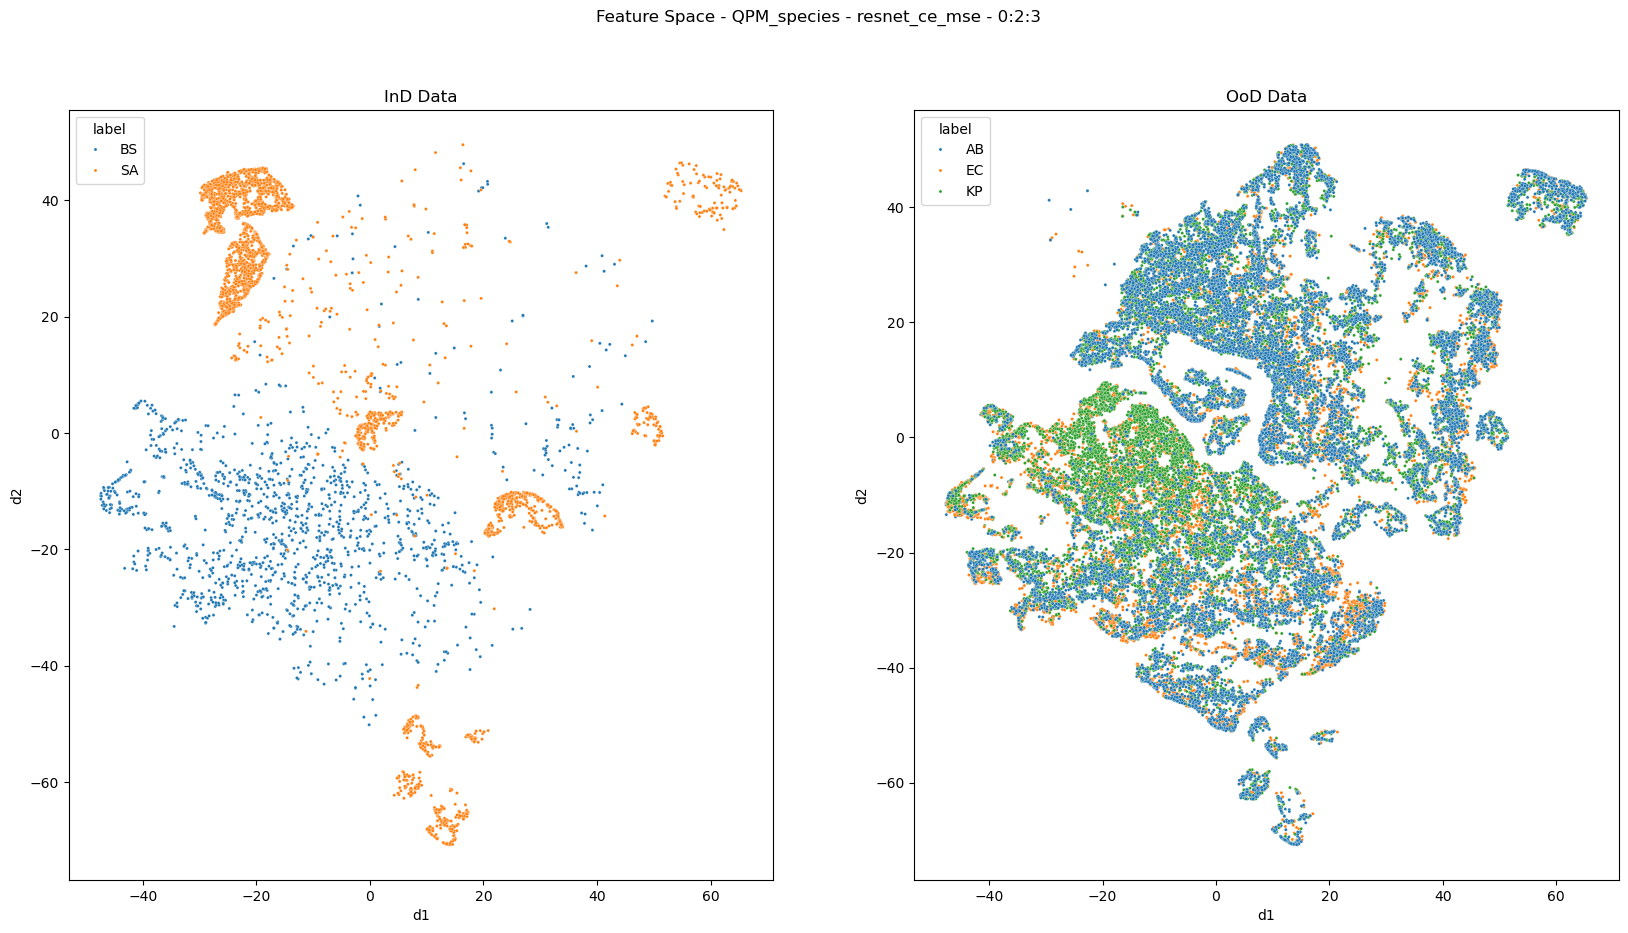

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

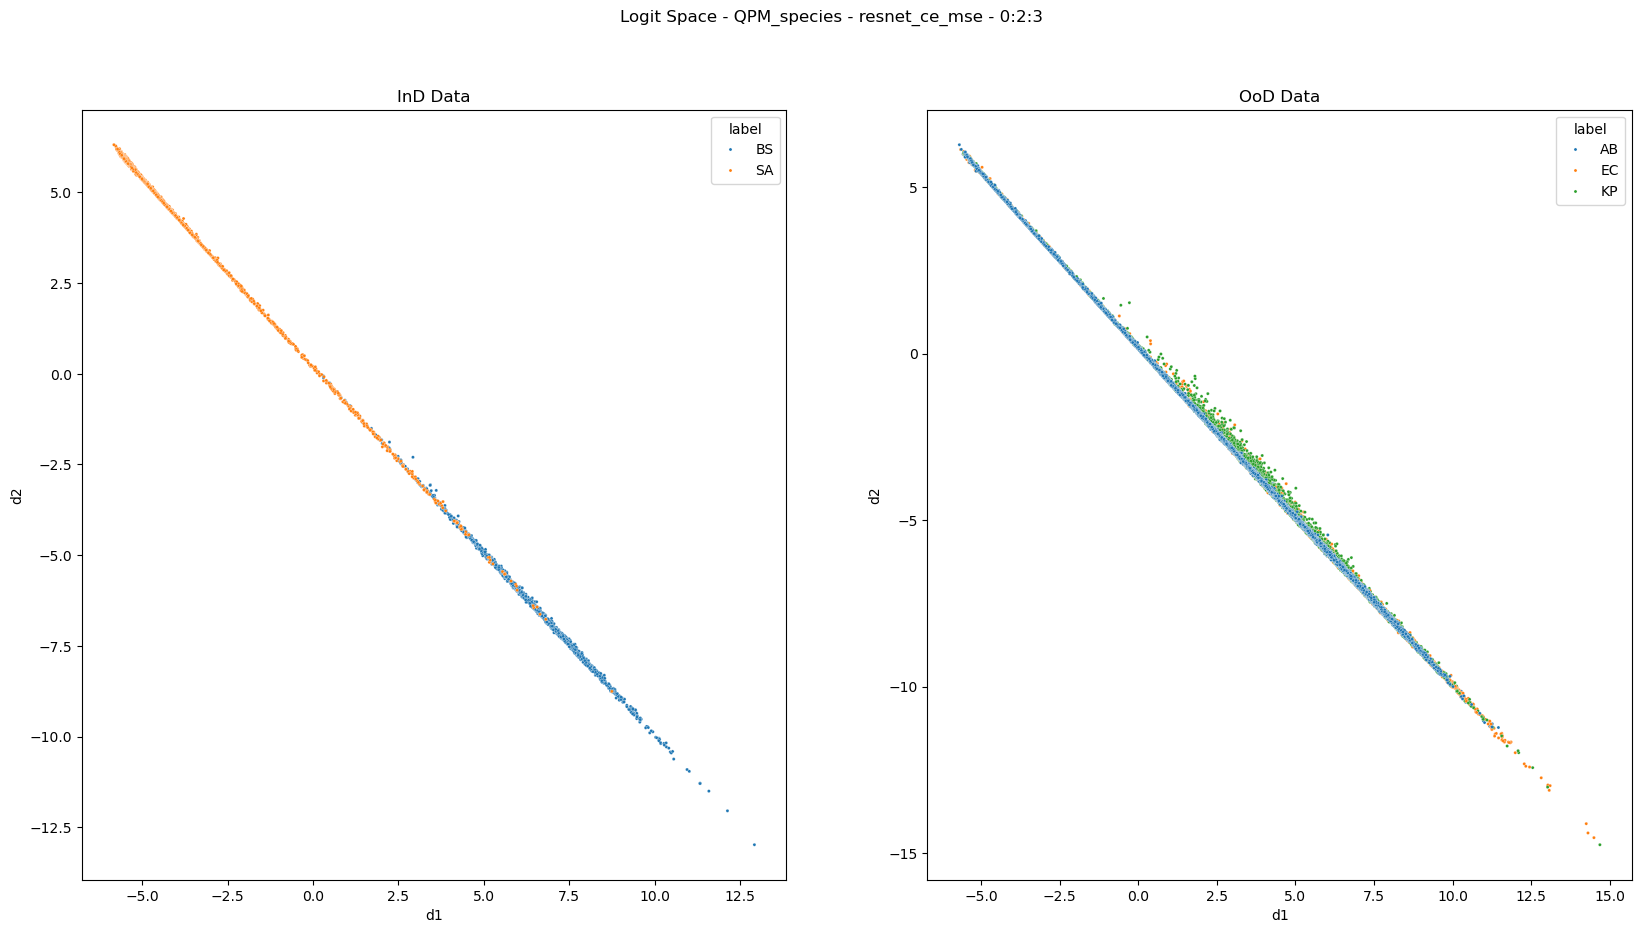

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  2.00s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.10s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.11s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.19s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it]

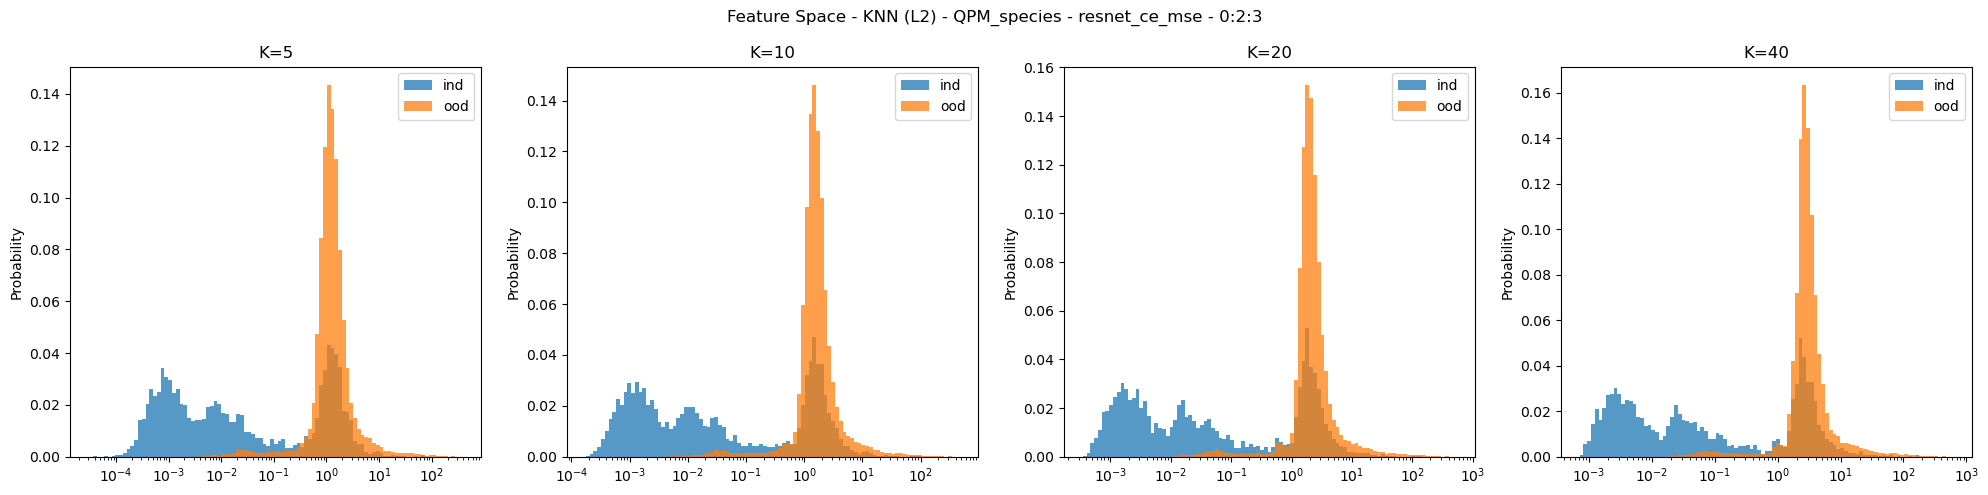

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.92s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.94s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it]

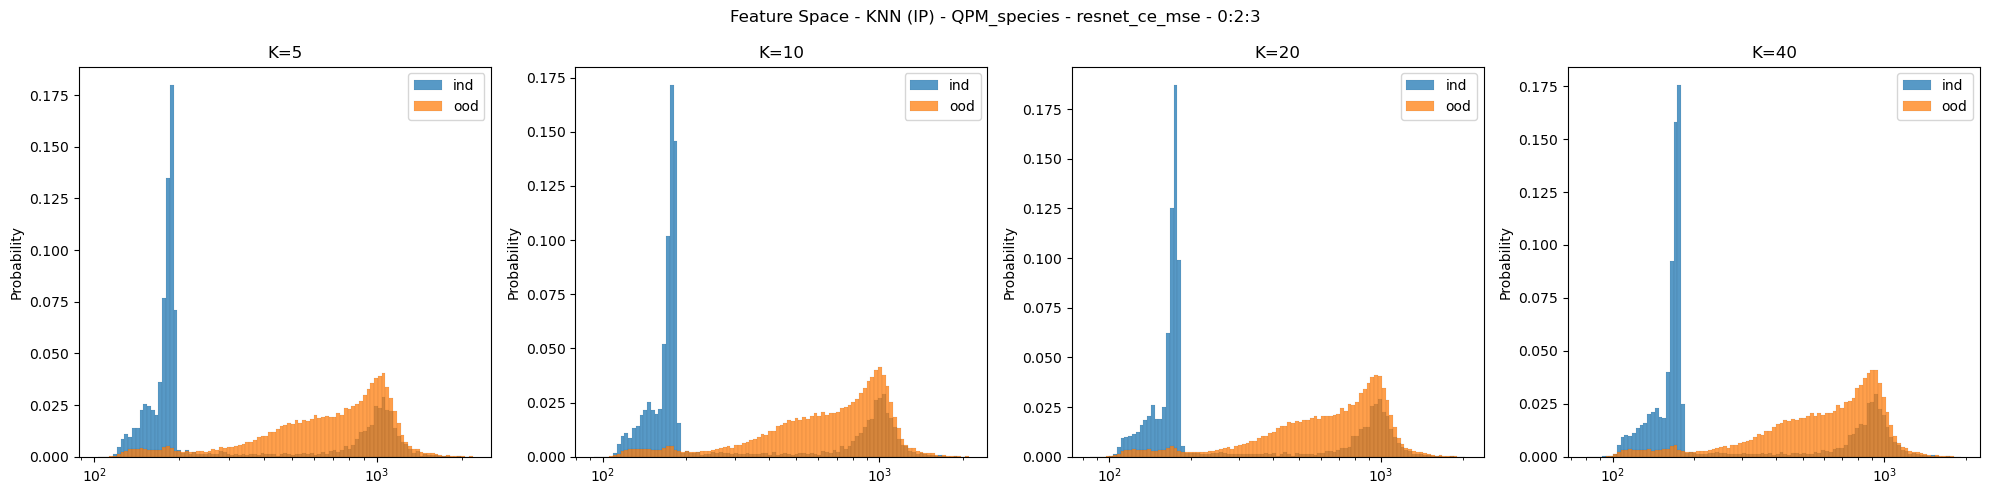

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.54it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.43it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.21it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.85it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]

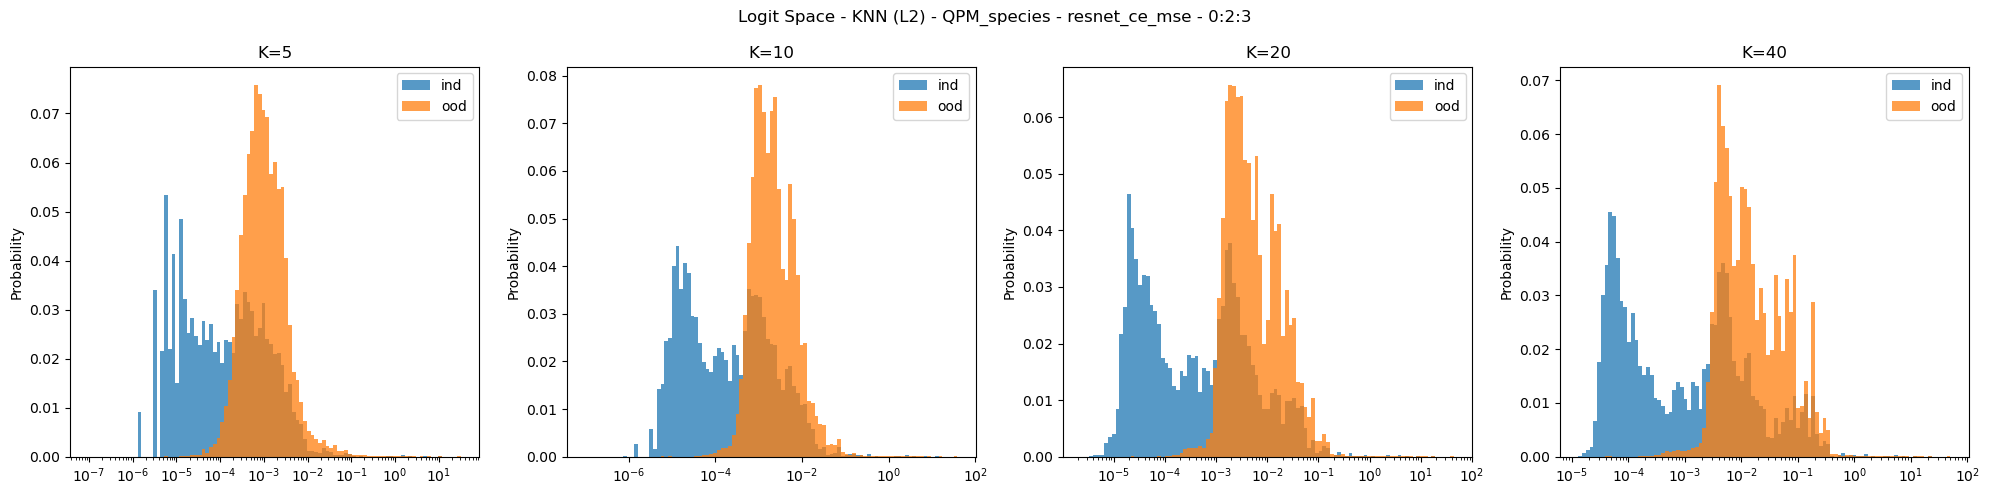

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.91it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.89it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.79it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]

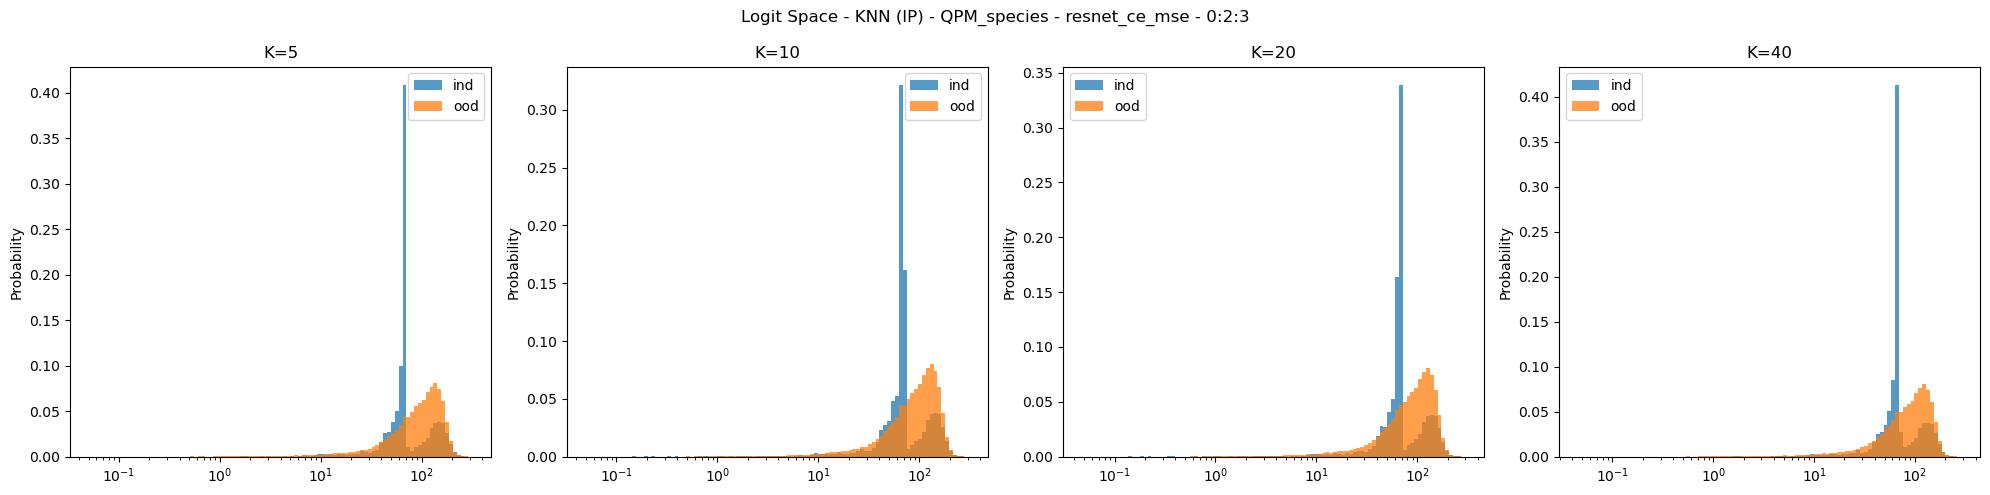

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

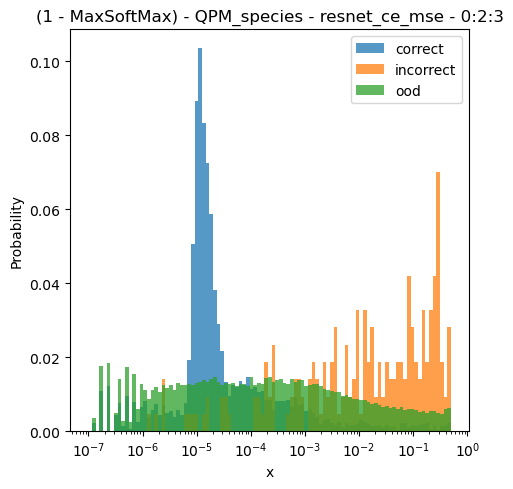

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

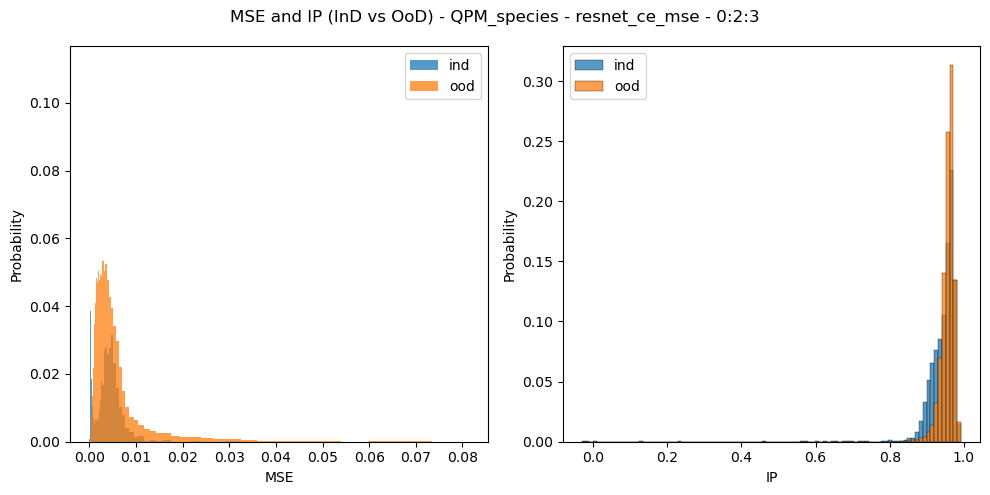

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()